In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats.stats import pearsonr
from processing_functions import add_unique_identifier, data_split

In [87]:
data = pd.read_csv('priv_mcare_f_pay.csv')
data = add_unique_identifier(data)
model_data, future_data = data_split(data, count_col_name = 'priv_count')
data = model_data

In [88]:
data.head()

,id,msa,year,site,group,priv_count,priv_pay_mean,priv_pay_median,priv_pay_iqr,mcare_los,mcare_pay_mean,mcare_pay_median,mcare_pay_sd,CBSA_NAME,State,FIPS State Code,lon,lat
89,19124_2018_Inpatient_breast reconstruction,19124,2018,Inpatient,breast reconstruction,63.0,25814.23349,24289.900,9988.0200,2.549296,9154.042394,8794.190,8531.770885,"Dallas-Fort Worth-Arlington, TX",Texas,48,-96.920913,32.707875
167,26420_2018_Inpatient_breast reconstruction,26420,2018,Inpatient,breast reconstruction,51.0,47327.57647,21408.000,23351.7150,3.543210,14027.076170,10395.160,12242.654150,"Houston-The Woodlands-Sugar Land, TX",Texas,48,-95.622552,29.598443
261,35614_2018_Inpatient_breast reconstruction,35614,2018,Inpatient,breast reconstruction,64.0,34224.02328,29757.100,30183.4325,3.918699,15671.588210,14174.100,15239.924130,"New York-Newark-Jersey City, NY-NJ-PA",New Jersey,34,-74.005954,40.712776
496,19124_2019_Inpatient_breast reconstruction,19124,2019,Inpatient,breast reconstruction,66.0,25969.48894,25240.905,10556.0675,3.241935,11425.032420,10144.445,8905.023478,"Dallas-Fort Worth-Arlington, TX",Texas,48,-96.920913,32.707875
1222,10420_2018_Outpatient_breast reconstruction,10420,2018,Outpatient,breast reconstruction,60.0,11218.48500,6998.350,6852.0150,0.000000,3310.623846,3487.540,1550.111451,"Akron, OH",Ohio,39,-81.519005,41.081445


# S0101 - Age and Sex data

### Merging datasets

In [89]:
age_sex = pd.read_csv('Age_Sex_Data/ACSST1Y2021.S0101-Data.csv')
age_sex.columns = ['GEO_ID','Name','total_population','median_age','sex_ratio']

In [91]:
# there are 18 MSAs in the data for which we do not have population attributes
no_match_areas = set(data.CBSA_NAME) - set(age_sex.Name)
print(len(no_match_areas))

13


In [92]:
potential_match = {}
for area in no_match_areas:
    potential_match[area] = []
    state = area.split(', ')[-1]
    county_names = area.split(', ')[0].split(' ')
    for x in set(age_sex.Name):
        if state in x:
            if len(set(county_names).intersection(set(x.split(', ')[0].split( ))))!=0:
                potential_match[area].append(x)

In [93]:
potential_match

{'San Francisco-Redwood City-South San Francisco, CA': ['San Jose-Sunnyvale-Santa Clara, CA',
  'San Francisco-Oakland-Berkeley, CA',
  'San Diego-Chula Vista-Carlsbad, CA',
  'San Luis Obispo-Paso Robles, CA'],
 'Silver Spring-Frederick-Rockville, MD': [],
 'Fort Lauderdale-Pompano Beach-Deerfield Beach, FL': ['Deltona-Daytona Beach-Ormond Beach, FL',
  'Miami-Fort Lauderdale-Pompano Beach, FL',
  'Sebastian-Vero Beach, FL'],
 'Chicago-Naperville-Arlington Heights, IL': [],
 'West Palm Beach-Boca Raton-Delray Beach, FL': ['Deltona-Daytona Beach-Ormond Beach, FL',
  'Miami-Fort Lauderdale-Pompano Beach, FL',
  'Sebastian-Vero Beach, FL',
  'Key West, FL',
  'Palm Bay-Melbourne-Titusville, FL'],
 'Los Angeles-Long Beach-Glendale, CA': ['Los Angeles-Long Beach-Anaheim, CA'],
 'Anaheim-Santa Ana-Irvine, CA': [],
 'Miami-Miami Beach-Kendall, FL': [],
 'Tacoma-Lakewood, WA': [],
 'Oakland-Hayward-Berkeley, CA': [],
 'Seattle-Bellevue-Everett, WA': [],
 'Dayton, OH': [],
 'Dutchess County-Pu

In [96]:
data_age_sex = pd.merge(data, age_sex, left_on = 'CBSA_NAME', right_on = 'Name')
data_age_sex.dropna(subset = ['priv_count','priv_pay_mean'], inplace = True)

In [226]:
data_age_sex.head(2)

,id,msa,year,site,group,priv_count,priv_pay_mean,priv_pay_median,priv_pay_iqr,mcare_los,...,CBSA_NAME,State,FIPS State Code,lon,lat,GEO_ID,Name,total_population,median_age,sex_ratio
0,19124_2018_Inpatient_breast reconstruction,19124,2018,Inpatient,breast reconstruction,63.0,25814.23349,24289.900,9988.0200,2.549296,...,"Dallas-Fort Worth-Arlington, TX",Texas,48,-96.920913,32.707875,310M600US19100,"Dallas-Fort Worth-Arlington, TX",7759615,35.6,97.9
1,19124_2019_Inpatient_breast reconstruction,19124,2019,Inpatient,breast reconstruction,66.0,25969.48894,25240.905,10556.0675,3.241935,...,"Dallas-Fort Worth-Arlington, TX",Texas,48,-96.920913,32.707875,310M600US19100,"Dallas-Fort Worth-Arlington, TX",7759615,35.6,97.9


## Cor

In [113]:
data_age_sex.corr()

,msa,year,priv_count,priv_pay_mean,priv_pay_median,priv_pay_iqr,mcare_los,mcare_pay_mean,mcare_pay_median,mcare_pay_sd,FIPS State Code,lon,lat,total_population,median_age,sex_ratio
msa,1.000000,0.001356,-0.019689,-0.012378,-0.012145,-0.008406,0.005769,-0.008223,-0.000244,-0.015759,0.039041,-0.069613,0.075994,0.070520,0.099171,0.047809
year,0.001356,1.000000,-0.074167,0.034527,0.034740,0.028305,-0.027745,0.041580,0.043910,0.034581,-0.012624,0.005720,-0.012554,0.029794,-0.029246,-0.010172
priv_count,-0.019689,-0.074167,1.000000,-0.123504,-0.125316,-0.082813,-0.110141,-0.128689,-0.128432,-0.084094,0.047963,0.023327,-0.045280,0.250530,-0.074582,-0.045473
priv_pay_mean,-0.012378,0.034527,-0.123504,1.000000,0.961165,0.861011,0.596193,0.882323,0.866203,0.696924,0.073978,0.015633,-0.080922,0.233340,-0.060853,-0.012119
priv_pay_median,-0.012145,0.034740,-0.125316,0.961165,1.000000,0.784257,0.547686,0.866948,0.876164,0.607570,0.073138,0.023258,-0.064271,0.209286,-0.054922,-0.012723
priv_pay_iqr,-0.008406,0.028305,-0.082813,0.861011,0.784257,1.000000,0.384811,0.734074,0.722316,0.531015,0.053291,-0.009112,-0.084794,0.292429,-0.063657,0.031264
mcare_los,0.005769,-0.027745,-0.110141,0.596193,0.547686,0.384811,1.000000,0.699686,0.609641,0.849349,0.013926,0.076848,-0.022948,0.152860,-0.005842,-0.084017
mcare_pay_mean,-0.008223,0.041580,-0.128689,0.882323,0.866948,0.734074,0.699686,1.000000,0.981367,0.783388,0.024495,0.062797,0.011175,0.223380,-0.021075,-0.067573
mcare_pay_median,-0.000244,0.043910,-0.128432,0.866203,0.876164,0.722316,0.609641,0.981367,1.000000,0.678822,0.019754,0.064649,0.025833,0.216460,-0.010989,-0.068391
mcare_pay_sd,-0.015759,0.034581,-0.084094,0.696924,0.607570,0.531015,0.849349,0.783388,0.678822,1.000000,0.037484,0.062299,-0.021398,0.206469,-0.039023,-0.073252


### Calculating correlations per group

In [211]:
pvalue_group_df = pd.DataFrame(columns = ['group','total_population','median_age','sex_ratio'])
pvalue_group_df['group'] = np.unique(data_age_sex.group)

corr_group_df = pd.DataFrame(columns = ['group','total_population','median_age','sex_ratio'])
corr_group_df['group'] = np.unique(data_age_sex.group)

In [212]:
alpha = 0.05
groups_removed = []
for col in pvalue_group_df.columns[1:]:
    pvalues = []
    corr = []
    for group in np.unique(pvalue_group_df.group):
        temp = data_age_sex[data_age_sex.group == group]
        if temp.shape[0]<=2:
            pvalues.append(np.nan)
            corr.append(np.nan)
            if group not in groups_removed:
                groups_removed.append(group)
        else:
            coeff,pv = pearsonr(temp.priv_pay_mean,temp[col])
            pvalues.append(pv)
            corr.append(coeff)
    pvalue_group_df[col] = pvalues
    corr_group_df[col] = corr

pvalue_group_df.index = pvalue_group_df.group
pvalue_group_df.drop(columns = ['group'], inplace = True)

corr_group_df.index = corr_group_df.group
corr_group_df.drop(columns = ['group'], inplace = True)

8 procedure groups had less than 2 observations in the model data and so were not included in correlation analysis

In [213]:
groups_removed

['cardiac ablation_linear_focal',
 'clavicle fixation',
 'pka',
 'post_cerv_fusion',
 'prox_tibia_fixation',
 'thoracic',
 'tpa',
 'tsa']

In [224]:
labels = corr_group_df.dropna().copy()
for group in labels.index:
    for col in labels.columns:
        if pvalue_group_df[col][group] >= 0.05:
            labels[col][group] = np.nan

labels = labels.round(2)
annotations = labels.astype(str)
annotations[np.isnan(labels)] = ""

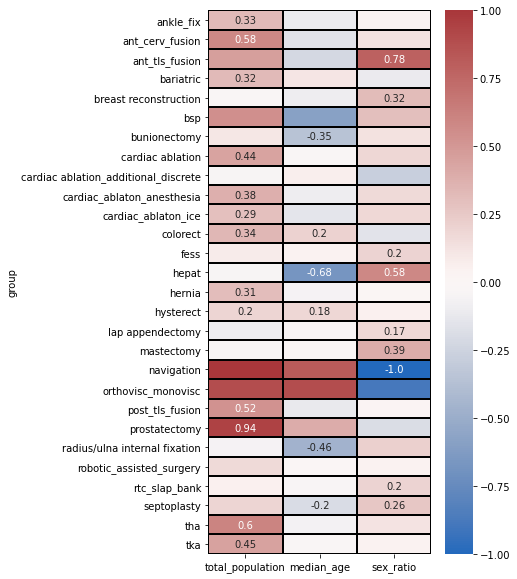

In [225]:
plt.figure(figsize = (5,10))
sns.heatmap(corr_group_df.dropna(),vmin=-1, vmax=1, center = 0, cmap = 'vlag', linecolor = 'black', \
            linewidth = 0.2, annot = annotations, fmt = 's')
plt.show()

In [200]:
pvalue_group_df

,total_population,median_age,sex_ratio
group,,,
ankle_fix,1.086930e-03,0.304081,6.794212e-01
ant_cerv_fusion,2.205313e-08,0.166871,2.527971e-01
ant_tls_fusion,2.439036e-01,0.593305,2.157122e-02
bariatric,1.555860e-05,0.148775,1.485505e-01
breast reconstruction,7.894252e-01,0.219305,3.005732e-05
bsp,4.532669e-01,0.408587,7.031179e-01
bunionectomy,2.782544e-01,0.000127,1.674788e-01
cardiac ablation,2.078997e-06,0.838622,5.786840e-02
cardiac ablation_additional_discrete,8.936623e-01,0.838981,3.845757e-01
